In [4]:
import pandas as pd

In [144]:
import pandas as pd

merged = pd.read_csv('ubs-lauzhack-2024/external_parties_train.csv')
merged.head()

,transaction_reference_id,party_role,party_info_unstructured,parsed_name,parsed_address_street_name,parsed_address_street_number,parsed_address_unit,parsed_address_postal_code,parsed_address_city,parsed_address_state,parsed_address_country,party_iban,party_phone,external_id
0,04ff0d1c680189e3a80c92d86407f0f5,BENE,mary mith 107 107 angela brooks n. thomasfurt ...,mary mith,angela brooks,107 107,NaN,NaN,n. thomasfurt,NaN,bulgaria,GB49MYOB82127728573340,+1.815660-6791x8486,50039037
1,439ab0ad7380e6135ab2ff3fddd4a727,ORG,yesneia kim north michael 93971 koribati,yesneia kim,north michael,NaN,NaN,93971,koribati,NaN,NaN,NaN,0 (269)620-8734x2349,60044692
2,00cac12d41191a84f9e31aa731a83512,ORG,w. roberson jr. 41010 rachel crossingapt. 923 ...,w. roberson jr.,rachel crossingapt.,41010 923,NaN,p2235417,thompsonshire amyport,NaN,NaN,GB08OTHR53515837682953,NaN,30008244
3,e4fba5f878dd3453e35973605a783a16,BENE,azquez-nelson co. suarez ports suite & 024 bri...,azquez-nelson co.,ports suite &,NaN,NaN,NaN,brittanyberg,NaN,bulgaria bulgaria,GB17VVGW66321494633280,NaN,40017944
4,d03d7e4c31878b0255d39e8c3f0ab625,ORG,m.j. bytd iii 856 john lake s. glenn cocos (ke...,m.j. bytd iii,john lake s. glenn,856,NaN,125838276,cocos (keeling),islands,NaN,NaN,(260)3371534,40012658


In [145]:
# Group by external_id and count occurrences, then merge back with original dataframe
id_counts = merged['external_id'].value_counts().reset_index()
id_counts.columns = ['external_id', 'count']

# Merge the counts with original dataframe
merged = merged.merge(id_counts, on='external_id')

# Sort by count in descending order, then drop the count column
merged = merged.sort_values(by=['count', 'external_id'], ascending=False)

merged.to_csv('merged_with_counts.csv', index=False)

In [25]:
import re

def clean_phone_numbers(phone_numbers):
    """
    Cleans a list of phone numbers by removing 
    alphabetical characters, dashes, underscores, spaces, and plus signs, ...
    
    Args:
        phone_numbers (list of str): List of phone numbers to clean.
    
    Returns:
        list of str: Cleaned phone numbers.
    """
    cleaned_numbers = [re.sub(r'[a-zA-Z\-\_\s\+\.\,\'\^\(\)]', '', str(phone)) for phone in phone_numbers]
    return cleaned_numbers

In [26]:
# Get from geopandas the list of all countries
import geopandas as gpd
from rapidfuzz import process, fuzz

# Compare each country with the list of countries in world and compute the similarity
def get_closest_country(name):
    country = process.extract(name, world['name'], scorer=fuzz.ratio, limit=3)
    for c in country:
        if country[0][1] > 85:
            return c[0]
    return None

# Get the list of the countries in the world
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
world['name'] = world['name'].str.lower()


# For the countries where the length is even check if the same name is repeated twice. If so fix it
countries = merged['parsed_address_country'].dropna().unique()
for country in countries:
    if  len(country.split(" ")) % 2 == 0:
        country_split = country.split(" ")
        if ' '.join(country_split[:len(country_split)//2]) == ' '.join(country_split[len(country_split)//2:]):
            merged['parsed_address_country'] = merged['parsed_address_country'].replace(country, ' '.join(country_split[:len(country_split)//2]))

# Get the list of countries that are not in the world list
countries = merged['parsed_address_country'].dropna().unique()
remapping = {}
to_remove = []
for country in countries:
    results = get_closest_country(country)
    if results is not None:
        remapping[country] = results
    else:
        to_remove.append(country)


In [27]:
from collections import defaultdict
import re

def normalize_name(name):
    # Convert to lowercase and strip whitespace
    name = name.lower().strip()
    
    # Define all patterns to remove
    patterns = {
        # Titles
        r'\b(dr\.|mr\.|mrs\.|ms\.|prof\.)\s*': '',
        # Suffixes 
        r'\s+(jr\.|sr\.|ii|iii|md|dvm)\b': '',
        # Business entities
        r'\s+(ltd|llc|inc|corp|s\.a\.r\.l\.|p\.l\.c\.|group|grp\.)\b': '',
        # Multiple spaces
        r'\s+': ' '
    }
    
    # Apply all patterns in a single pass
    for pattern, repl in patterns.items():
        name = re.sub(pattern, repl, name)
        
    return name



In [28]:
    
# Remap the countries
merged['parsed_address_country'] = merged['parsed_address_country'].replace(remapping)

print('replaced countries')

# Put to nan the countries that are in the to_remove list
merged['parsed_address_country'] = merged['parsed_address_country'].replace(to_remove, None)

merged['party_phone'] = clean_phone_numbers(merged['party_phone'])

print('cleaned phone numbers')

merged['parsed_name'] = merged['parsed_name'].apply(normalize_name)



replaced countries
cleaned phone numbers


In [29]:
# merged.to_csv('test_cleaned.csv', index=False)

# merged = pd.read_csv('test_cleaned.csv')

In [40]:
filtered = merged[['transaction_reference_id', 'parsed_name', 'parsed_address_country', 'party_phone', 'party_iban', 'external_id']]
# filtered = merged[['transaction_reference_id', 'parsed_name', 'parsed_address_country', 'party_phone', 'party_iban', 'external_id']]

In [31]:
# Set to an incremental number the names that are most likely

In [121]:
import pandas as pd
import networkx as nx
from collections import defaultdict
from tqdm import tqdm

def create_weighted_similarity_graph(df, column_weights):
    # Initialize graph
    G = nx.Graph()
    
    # Create mapping from index to transaction ID
    idx_to_txn = dict(zip(df.index, df['transaction_reference_id']))
    
    # Add all rows as nodes first, using transaction IDs
    for idx in tqdm(df.index, desc="Adding nodes"):
        G.add_node(idx_to_txn[idx])
    
    # Create value-to-nodes mapping for each column
    column_mappings = {}
    for column in tqdm(column_weights.keys(), desc="Processing columns"):
        if column != 'transaction_reference_id':
            column_mappings[column] = defaultdict(list)
            
            # For each value in the column, store the transaction IDs that contain it
            for idx, value in tqdm(df[column].items(), desc=f"Processing {column}", leave=False):
                if pd.notna(value) and value != '':  # Skip empty/NaN values
                    column_mappings[column][value].append(idx_to_txn[idx])
    
    # Create edges between nodes that share values, with weights
    for column, value_map in tqdm(column_mappings.items(), desc="Creating edges"):
        weight = column_weights[column]  # Get weight from column_weights
        for value, nodes in tqdm(value_map.items(), desc=f"Processing {column} values", leave=False):
            # Skip adding edges for parsed_name if it appears more than 100 times
            if column == 'parsed_name' and len(nodes) > 10:
                continue
            # If multiple nodes share this value, create edges between them
            if len(nodes) > 1:
                for i in range(len(nodes)):
                    for j in range(i + 1, len(nodes)):
                        G.add_edge(nodes[i], nodes[j], weight=weight)
    
    return G

# Example usage
column_weights = {
    'parsed_name': 0.2,
    # 'parsed_address_country': 0.1,
    'party_phone': 1,
    'party_iban': 1,
}

no_label = filtered.drop(columns=['external_id']) if 'external_id' in filtered.columns else filtered

# Create the graph with weights
G = create_weighted_similarity_graph(no_label, column_weights)

# If you want to convert back to a DataFrame showing connections with weights:
edges_df = pd.DataFrame([(u, v, d['weight']) for u, v, d in tqdm(G.edges(data=True), desc="Creating DataFrame")], columns=['node1', 'node2', 'weight'])

Creating DataFrame: 100%|██████████| 11453/11453 [00:00<00:00, 1861408.29it/s]


In [122]:
# Compute connected components
components = list(nx.connected_components(G))

In [128]:
# Create a dictionary to store component assignments
component_dict = {}

# Assign an ID to each component
for i, component in enumerate(components):
    for node in component:
        component_dict[node] = i

# Convert to DataFrame
component_df = pd.DataFrame([(transaction_id, component_id) for transaction_id, component_id in component_dict.items()], columns=['transaction_reference_id', 'external_id'])


In [133]:

# Print details for each of the 10 largest components
for i, component_id in enumerate(component_df['external_id'].values):
    # Get transaction IDs for this component
    component_transactions = component_df[component_df['external_id'] == component_id]['transaction_reference_id']
    
    # Get transactions in this component
    component_data = filtered[filtered['transaction_reference_id'].isin(component_transactions)]
    
    # Check if there are different external_ids in the component
    if len(component_data['external_id'].unique()) > 1:
        print(f"\nComponent {i+1} has transactions with different external_ids:")
        print(component_data)



Component 8 has transactions with different external_ids:
              transaction_reference_id parsed_name parsed_address_country  \
5     948ae2b2fa0a7cafb33978779f443429      flores                   None   
4016  46b6607bbfb9e4b1dc406e2c4ac7e349      flores                    NaN   
6827  a46f38d8bf4ac04a9f961f2793e1088a      flores               ethiopia   

           party_phone              party_iban  external_id  
5       88013204104875  GB98QFKA10998873694870     10420140  
4016  4150135561336851  GB35OCSO29373264473902     10310572  
6827                    GB80TQCA51796208283093     10400788  

Component 9 has transactions with different external_ids:
              transaction_reference_id parsed_name parsed_address_country  \
5     948ae2b2fa0a7cafb33978779f443429      flores                   None   
4016  46b6607bbfb9e4b1dc406e2c4ac7e349      flores                    NaN   
6827  a46f38d8bf4ac04a9f961f2793e1088a      flores               ethiopia   

           party

In [125]:
# Group by external_id in filtered data and check component assignments
for ext_id in filtered['external_id'].unique():
    # Get transactions with this external_id
    transactions = filtered[filtered['external_id'] == ext_id]['transaction_reference_id']
    
    # Get component assignments for these transactions
    component_assignments = component_df[component_df['transaction_reference_id'].isin(transactions)]['external_id']
    
    # Check if transactions with same external_id got assigned to different components
    if len(component_assignments.unique()) > 1:
        print(f"\nExternal ID {ext_id} has transactions in different components:")
        print(filtered[filtered['external_id'] == ext_id])


External ID 40017944 has transactions in different components:
              transaction_reference_id                         parsed_name  \
3     e4fba5f878dd3453e35973605a783a16                   azquez-nelson co.   
4022  bbe6b00bbc83e0481e59dd2881a5d5a1     asquez-nelson asquez-nelson co.   
4423  eada0b4721df90ff287e1c2a77ef827f  vasquez-nelson vasquez-nelson grp.   

     parsed_address_country party_phone              party_iban  external_id  
3                  bulgaria              GB17VVGW66321494633280     40017944  
4022                    NaN                                 NaN     40017944  
4423               bulgaria              GB31MLER26108251407200     40017944  

External ID 40012658 has transactions in different components:
              transaction_reference_id parsed_name parsed_address_country  \
4     d03d7e4c31878b0255d39e8c3f0ab625   m.j. bytd                    NaN   
5517  cac68f99c7dd7af4e8ca788463c20bba     j. byrd                   None   
6573  de599e

<AxesSubplot: >

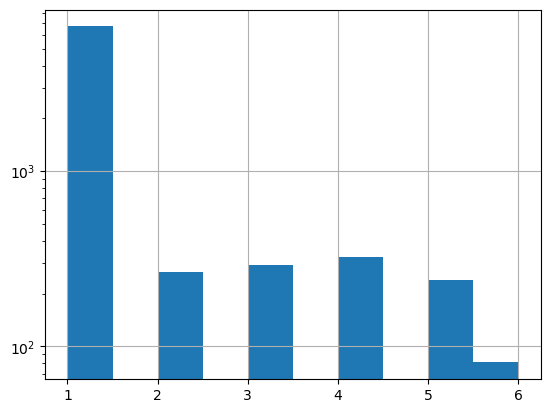

In [126]:
clusters_louvain["external_id"].value_counts().hist(log=True)

In [82]:
clusters_louvain.to_csv('clusters_louvain.csv', index=False)

In [130]:
def compute_clustering_metrics(df1, df2):
    """
    Compute precision, recall, and F1 score for clustering assignments
    
    Args:
        df1: DataFrame with columns [transaction_reference_id, external_id]
        df2: DataFrame with columns [transaction_reference_id, external_id]
    
    Returns:
        dict: Contains precision, recall, and F1 score
    """
    # Create dictionaries mapping transaction_id to cluster_id for both dataframes
    clusters1 = dict(zip(df1['transaction_reference_id'], df1['external_id']))
    clusters2 = dict(zip(df2['transaction_reference_id'], df2['external_id']))
    
    # Get all unique transaction IDs
    all_ids = list(clusters1.keys())
    n = len(all_ids)
    
    # Initialize counters for confusion matrix
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    # Compare all possible pairs
    for i in tqdm(range(n)):
        for j in range(i + 1, n):
            id1, id2 = all_ids[i], all_ids[j]
            
            # Check if pairs are in same cluster in both assignments
            same_cluster1 = clusters1[id1] == clusters1[id2]
            same_cluster2 = clusters2[id1] == clusters2[id2]
            
            if same_cluster1 and same_cluster2:
                true_positive += 1
            elif same_cluster1 and not same_cluster2:
                false_positive += 1
            elif not same_cluster1 and same_cluster2:
                false_negative += 1
    
    # Calculate metrics
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Usage:
metrics = compute_clustering_metrics(filtered, component_df)
print(f"Precision: {metrics['precision']:.3f}")
print(f"Recall: {metrics['recall']:.3f}")
print(f"F1 Score: {metrics['f1']:.3f}")

100%|██████████| 11064/11064 [00:07<00:00, 1421.26it/s]

Precision: 0.820
Recall: 0.903
F1 Score: 0.860


In [52]:
clusters_louvain, filtered[['external_id', 'transaction_reference_id']]

(               transaction_reference_id  external_id
 0      04ff0d1c680189e3a80c92d86407f0f5            0
 1      439ab0ad7380e6135ab2ff3fddd4a727            1
 2      00cac12d41191a84f9e31aa731a83512            2
 3      e4fba5f878dd3453e35973605a783a16            3
 4      d03d7e4c31878b0255d39e8c3f0ab625            4
 ...                                 ...          ...
 11059  7183d9c3700148c9527869948b685085          704
 11060  b47b9ed0a8cc9fcc4c21ac368fe79757          723
 11061  d61ff2b0184f32ad0021a313c6112b2e          250
 11062  bec335b1b1bad8c55b7dce549cfd8de0         5827
 11063  c2a8edf088268bddc15ec285ed730dbb         1876
 
 [11064 rows x 2 columns],
        external_id          transaction_reference_id
 0         50039037  04ff0d1c680189e3a80c92d86407f0f5
 1         60044692  439ab0ad7380e6135ab2ff3fddd4a727
 2         30008244  00cac12d41191a84f9e31aa731a83512
 3         40017944  e4fba5f878dd3453e35973605a783a16
 4         40012658  d03d7e4c31878b0255d39e8c3f0ab625